<a href="https://colab.research.google.com/github/AShahLab/MultipleOcularDisorders_CV/blob/main/ML_Computer_Vision_Multiple_Ocular_Disorders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## The Data

Data is taken from a Kaggle contest: https://www.kaggle.com/c/vietai-advance-course-retinal-disease-detection/overview

The training data set contains 3,435 retinal images that represent multiple pathological disorders. The pathology classes and corresponding labels are included in the `train.csv` file, and each image can have more than one class (multiple pathologies).

The labels for each image are:

- opacity (0), 
- diabetic retinopathy (1), 
- glaucoma (2),
- macular edema (3),
- macular degeneration (4),
- retinal vascular occlusion (5)
- normal (6)

The test data set contains 350 unlabeled images.

# Task 1: Classification Model

We will start by importing the needed libraries and importing the data

In [ ]:
#Importing required preliminary libraries
import pandas as pd
import numpy as np
from google.colab import drive
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score,f1_score,precision_score,recall_score

from tqdm import tqdm
from tensorflow.keras.preprocessing import image
from sklearn.metrics import classification_report

In [ ]:
#We will mount the drive and provide the filepath and then create a dataframe with the test data
drive.mount('/content/drive')
filepath = '/content/drive/My Drive/Datasets/Midterm/Data/train/train.csv'
train=pd.read_csv(filepath)

Mounted at /content/drive


## EDA and Preprocessing

In [ ]:
#Check what the data looks like
train.head()

,filename,opacity,diabetic retinopathy,glaucoma,macular edema,macular degeneration,retinal vascular occlusion,normal
0,c24a1b14d253.jpg,0,0,0,0,0,1,0
1,9ee905a41651.jpg,0,0,0,0,0,1,0
2,3f58d128caf6.jpg,0,0,1,0,0,0,0
3,4ce6599e7b20.jpg,1,0,0,0,1,0,0
4,0def470360e4.jpg,1,0,0,0,1,0,0


The data is multi-labeled and already one-hot encoded. We can create a categories list of the labels that would help us in looping through the columns during analysis.

In [ ]:
#Get a list of pathology categories that we will be working with including the filename
categories=['filename','diabetic retinopathy','glaucoma','normal','other']
train['other']=np.where((train['diabetic retinopathy']==0)  & (train['glaucoma']==0) & (train['normal']==0),1,0)

In [ ]:
#Double check that the 'other' column was added correctly
train.head()

,filename,opacity,diabetic retinopathy,glaucoma,macular edema,macular degeneration,retinal vascular occlusion,normal,other
0,c24a1b14d253.jpg,0,0,0,0,0,1,0,1
1,9ee905a41651.jpg,0,0,0,0,0,1,0,1
2,3f58d128caf6.jpg,0,0,1,0,0,0,0,0
3,4ce6599e7b20.jpg,1,0,0,0,1,0,0,1
4,0def470360e4.jpg,1,0,0,0,1,0,0,1


We will now create a new dataset and get a more visual perspective of the distribution.

In [ ]:
#Reduce the data frame to only hold the data we will be working with and then take a look
df_train=train[categories]
df_train.head()

,filename,diabetic retinopathy,glaucoma,normal,other
0,c24a1b14d253.jpg,0,0,0,1
1,9ee905a41651.jpg,0,0,0,1
2,3f58d128caf6.jpg,0,1,0,0
3,4ce6599e7b20.jpg,0,0,0,1
4,0def470360e4.jpg,0,0,0,1


In [ ]:
#Drop filename column from the categories list since we will be looping through the pathologies in the future
categories.remove('filename')

In [ ]:
#Get the count of each category
print('Training data total rows: {}'.format(train.shape[0]))
for category in categories:
  print('Value count of {}: {}'.format(category,train[category].value_counts()[1]))

Training data total rows: 3435
Value count of diabetic retinopathy: 755
Value count of glaucoma: 597
Value count of normal: 525
Value count of other: 1577


Let's visualize the distribution of each category in our dataset

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, '# of Occurences')

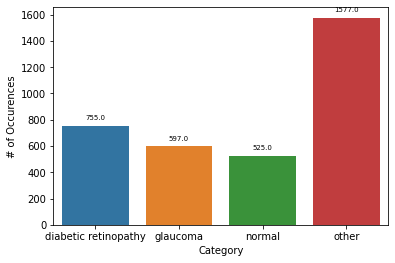

In [ ]:
#Visualize the distribution of each category
y=np.array(df_train[categories])
sum=np.sum(y,axis=0)

plots=sns.barplot(categories,sum)
for bar in plots.patches:
  plt.annotate(format(bar.get_height()),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=7, xytext=(0, 8),
                   textcoords='offset points')
plt.xlabel("Category")
plt.ylabel("# of Occurences")

In [ ]:
print('Looking for missing values in our training data for any category:\n{}'.format(df_train[categories].isnull().sum()))

Looking for missing values in our training data for any category:
diabetic retinopathy    0
glaucoma                0
normal                  0
other                   0
dtype: int64


The above analysis so far tells us that the data is imbalanced as you can see 'other' class has significantly more occurences than the other 3 classes.

In [ ]:
# Load images from directory and put into np array for training. Don't do this if you are running the code again
train_images = []
PATH = '/content/drive/My Drive/Datasets/Midterm/Data/train/train/'
img_size = 256
for i in tqdm(range(df_train.shape[0])):
  img = image.load_img(PATH+df_train['filename'][i], target_size=(img_size,img_size,3))
  img = image.img_to_array(img)
  img = img/255
  train_images.append(img)
X = np.array(train_images)

100%|██████████| 3435/3435 [13:29<00:00,  4.24it/s]


In [ ]:
#Save the numpy in folder. Don't do this if you are running the code again
with open('/content/drive/My Drive/Datasets/Midterm/Data/X.npy', 'wb') as f:
  np.save(f, X)

In [ ]:
# Load previously saved X data
X = np.load('/content/drive/My Drive/Datasets/Midterm/Data/X.npy')

In [ ]:
print('Values in X are between {} and {}'.format(np.min(X),np.max(X)))

Values in X are between 0.0 and 1.0


In [ ]:
# We will perform a 70/30 split for training and alidation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
print('Shape dimensions:\nX_train: {}\ny_train: {}\n\nX_val: {}\ny_val: {}'.format(X_train.shape,y_train.shape,X_val.shape,y_val.shape))

Shape dimensions:
X_train: (2404, 256, 256, 3)
y_train: (2404, 4)

X_val: (1031, 256, 256, 3)
y_val: (1031, 4)


In [ ]:
# # Load images from test directory and put into np array for training. Don't do this if you are running the code again
import os
test_images = []
TEST_PATH = '/content/drive/My Drive/Datasets/Midterm/Data/test/test/'
img_size = 256


# Load in the images
for filepath in os.listdir('/content/drive/My Drive/Datasets/Midterm/Data/test/test/'):
  img = image.load_img(os.path.join(TEST_PATH,filepath), target_size=(img_size,img_size,3))
  img = image.img_to_array(img)
  img = img/255
  test_images.append(img)
X_test = np.array(test_images)

In [ ]:
#save the numpy array to directory
with open('/content/drive/My Drive/Datasets/Midterm/Data/X_test.npy', 'wb') as f:
  np.save(f, X_test)

In [ ]:
# # Load previously saved X data
X_test = np.load('/content/drive/My Drive/Datasets/Midterm/Data/X_test.npy')

In [ ]:
#assigning width and height and depth(channels) dimensions
w=X_train.shape[1]
h=X_train.shape[1]
d=3
num_classes=y_train.shape[1]

Relative distribution of labels between training and test datasets

X_train.shape = (2404, 256, 256, 3)
X_test.shape  = (1031, 256, 256, 3)


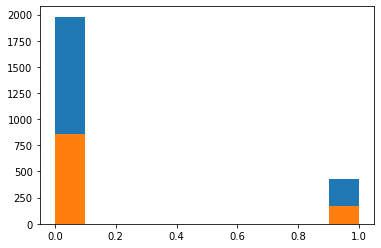

In [ ]:
plt.hist(y_train[:,1])
plt.hist(y_val[:,1])
print(f'X_train.shape = {X_train.shape}')
print(f'X_test.shape  = {X_val.shape}')

In [ ]:
#import additional libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [ ]:
#we will create a data augmentation pipeline with some preliminary augmentations
data_augmentation=keras.Sequential(
    [
     layers.RandomFlip("horizontal"),
     layers.RandomRotation(0.1),
    #  layers.RandomZoom(0.2),
    ]
)

Let's see the difference with basic flip and rotation augmentation on a single image

Before Augmentation:

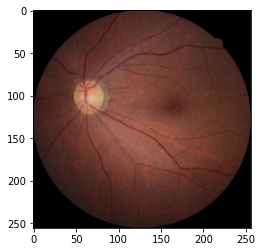

In [ ]:
plt.imshow(X_train[1])
plt.show()

After Augmentation:

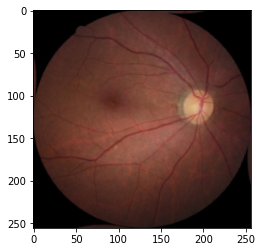

In [ ]:
plt.imshow(data_augmentation(X_train[1])[:])
plt.show()

Create a helper plotting function for use with our models

In [ ]:
def plot_loss_acc(history):
  acc = history.history["accuracy"]
  val_acc = history.history["val_accuracy"]
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]
  epochs = range(1, len(acc) + 1)
  plt.plot(epochs, acc, "bo", label="Training accuracy")
  plt.plot(epochs, val_acc, "b", label="Validation accuracy")
  plt.title("Training and validation accuracy")
  plt.legend()
  plt.figure()
  plt.plot(epochs, loss, "bo", label="Training loss")
  plt.plot(epochs, val_loss, "b", label="Validation loss")
  plt.title("Training and validation loss")
  return plt.show()

In [ ]:
Y_test = np.argmax(y_val, axis=-1) # Convert one-hot to index

If we train a model with these data-augmentation configurations then the model will never see the same input twice. Still, the inputs that are visible to it are heavily intercorrelated since they originate from a small number of original images. We will also add a Dropout layer to ensure regularization.
## MODEL 1:

We will kick off with AlexNet and see how it performs. We will use sigmoid activation function because this is a multi-class, multi-label problem where each category in non-exclusive. Adam seems like a reasonable choice to start with since it is generally the most popular option in literature. Our choice of binary_crossentropy comes from the fact that each category can either be 1 or 0. We do have that condition of the normal class where it should be one if all other categories are 0, which could push us towards softmax but as you will see that is something the network would learn based on the only options for the normal category.

In [ ]:
#Create AlexNet class since keras does not support a pretrained AlexNet model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam

class AlexNet(Sequential):
    def __init__(self, input_shape, num_classes):
        super().__init__()
        self.add(Conv2D(96, kernel_size=(11, 11), strides= 4,
                        padding='valid', activation='relu',
                        input_shape= input_shape, kernel_initializer='he_normal'))
        self.add(BatchNormalization())
        self.add(MaxPooling2D(pool_size=(3, 3), strides= (2, 2),
                              padding='valid', data_format=None))


        self.add(Conv2D(256, kernel_size=(5, 5), strides= 1,
                        padding='same', activation='relu',
                        kernel_initializer='he_normal'))
        self.add(BatchNormalization())
        self.add(MaxPooling2D(pool_size=(3, 3), strides= (2, 2),
                              padding='valid', data_format=None)) 


        self.add(Conv2D(384, kernel_size=(3, 3), strides= 1,
                        padding='same', activation='relu',
                        kernel_initializer='he_normal'))
        self.add(BatchNormalization())

        self.add(Conv2D(384, kernel_size=(3, 3), strides= 1,
                        padding='same', activation='relu',
                        kernel_initializer='he_normal'))
        self.add(BatchNormalization())

        self.add(Conv2D(256, kernel_size=(3, 3), strides= 1,
                        padding='same', activation='relu',
                        kernel_initializer='he_normal'))
        self.add(BatchNormalization())

        self.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2),
                              padding='valid', data_format=None))


        self.add(Flatten())

        self.add(Dense(num_classes, activation='sigmoid'))

        self.compile(optimizer=Adam(learning_rate=0.01),
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

In [ ]:
#initiate a new instance of the AlexNet model
Alex_model=AlexNet(input_shape=X_train.shape[1:],num_classes=y_train.shape[1])

In [ ]:
#check the details of the mdoels
Alex_model.summary()

Model: "alex_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 62, 62, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 30, 30, 256)      1024      
 hNormalization)                                                 
                                                          

Let's create a tensorboard callback and then fit our model

In [ ]:
#create a tensorborad callback inside the logs dir of our pwd
from datetime import datetime
import datetime,os
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [ ]:
#fit our model to the training data split from earlier
Alex_history=Alex_model.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=50,batch_size=20,verbose=1,callbacks=[tensorboard_callback])

print("Average test loss: ", np.mean(Alex_history.history['loss']))

Epoch 1/50
121/121 [==============================] - 15s 44ms/step - loss: 3.2623 - accuracy: 0.4139 - val_loss: 7.6419 - val_accuracy: 0.2008
Epoch 2/50
121/121 [==============================] - 4s 34ms/step - loss: 0.8596 - accuracy: 0.4971 - val_loss: 2.1697 - val_accuracy: 0.5053
Epoch 3/50
121/121 [==============================] - 4s 34ms/step - loss: 0.4803 - accuracy: 0.5599 - val_loss: 0.8290 - val_accuracy: 0.5441
Epoch 4/50
121/121 [==============================] - 4s 34ms/step - loss: 0.4388 - accuracy: 0.5645 - val_loss: 0.5117 - val_accuracy: 0.5635
Epoch 5/50
121/121 [==============================] - 4s 34ms/step - loss: 0.4270 - accuracy: 0.5724 - val_loss: 0.4109 - val_accuracy: 0.5790
Epoch 6/50
121/121 [==============================] - 4s 34ms/step - loss: 0.4138 - accuracy: 0.5953 - val_loss: 0.4251 - val_accuracy: 0.5752
Epoch 7/50
121/121 [==============================] - 4s 34ms/step - loss: 0.4105 - accuracy: 0.6019 - val_loss: 0.4130 - val_accuracy: 0.591

In [ ]:
#Save the model architecture for future use
Alex_model.save('Alex_model.h5')

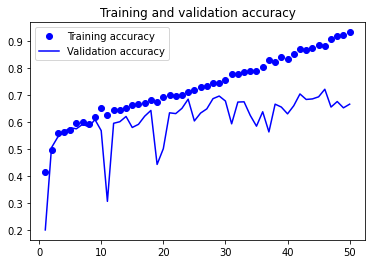

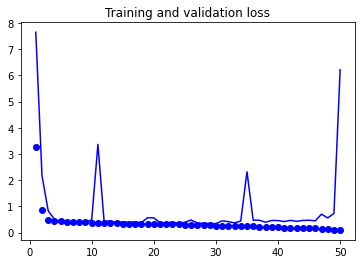

              precision    recall  f1-score   support

           0       0.46      0.65      0.54       237
           1       0.70      0.46      0.56       167
           2       0.96      0.88      0.92       155
           3       0.73      0.68      0.70       472

    accuracy                           0.67      1031
   macro avg       0.71      0.67      0.68      1031
weighted avg       0.70      0.67      0.68      1031



In [ ]:
#Let's use our plotting function to plot the results. We will also get the classification report with details of our output metrics
plot_loss_acc(Alex_history)
Alex_pred = np.argmax(Alex_model.predict(X_val),axis=-1)
print(classification_report(Y_test, Alex_pred))

In the above table: 

`0` is Diabetic Retinopathy  
`1` is Glaucoma  
`2` is Normal  
`3` is Other  

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
#Create an ImageDataGenerator object that would be used for data augmentation in our models
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)
datagen.fit(X_train)


In [ ]:
#Augment our training and validation datasets
train_generator = datagen.flow(X_train, y_train)
val_generator = datagen.flow(X_val, y_val)

In [ ]:
seed = 0
aug_batch_size = 6

Let's view a couple of the augmented data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 0
(6, 256, 256, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


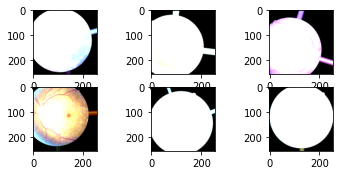

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[0 0 0 1]
 [1 0 0 0]
 [1 0 0 0]
 [0 0 0 1]
 [0 0 1 0]
 [1 0 0 0]]
Epoch 1
(6, 256, 256, 3)


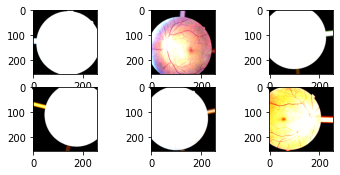

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[0 1 0 0]
 [0 0 0 1]
 [0 1 0 0]
 [0 0 0 1]
 [0 0 1 0]
 [0 0 1 0]]
Epoch 2
(6, 256, 256, 3)


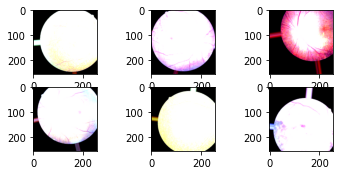

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [0 0 1 0]
 [0 0 0 1]
 [0 1 0 0]]
Epoch 3
(6, 256, 256, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


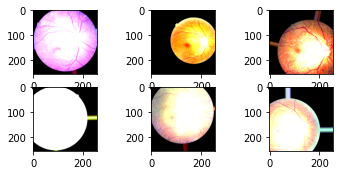

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[0 1 0 0]
 [0 0 1 0]
 [1 0 0 0]
 [0 0 0 1]
 [0 0 0 1]
 [0 0 0 1]]
Epoch 4
(6, 256, 256, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


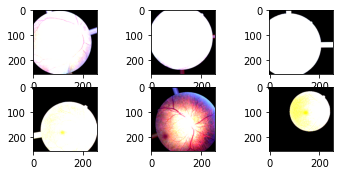

[[0 0 0 1]
 [1 0 0 0]
 [0 0 0 1]
 [0 0 1 0]
 [0 0 0 1]
 [0 0 1 0]]


In [ ]:
#Lets visualize 5 batches of 6 images from our training set
for e in range(5):
    print('Epoch', e)
    batches = 0
    for x_batch, y_batch in datagen.flow(X_train, y_train, batch_size=aug_batch_size):
        print(x_batch.shape)
        for i in range(0, aug_batch_size):
            plt.subplot(330+1 + i)
            plt.imshow(x_batch[i], cmap=plt.get_cmap('gray'))
        plt.show()
        print(y_batch)
        break

We will now apply the regularization to our AlexNet model

In [ ]:
model_reg = AlexNet((np.shape(X_train)[1],np.shape(X_train)[2], 3), num_classes=y_train.shape[1])


reg_history = model_reg.fit(
    train_generator,
    steps_per_epoch=50,
    verbose=1, 
    epochs=40,
    callbacks=[tensorboard_callback]
)

print("Average test loss: ", np.average(reg_history.history['loss']))

Epoch 1/40
50/50 [==============================] - 21s 398ms/step - loss: 4.1802 - accuracy: 0.4194
Epoch 2/40
50/50 [==============================] - 19s 389ms/step - loss: 1.9255 - accuracy: 0.4081
Epoch 3/40
50/50 [==============================] - 19s 388ms/step - loss: 1.3387 - accuracy: 0.4218
Epoch 4/40
50/50 [==============================] - 19s 387ms/step - loss: 0.7152 - accuracy: 0.4841
Epoch 5/40
50/50 [==============================] - 20s 391ms/step - loss: 0.6868 - accuracy: 0.4419
Epoch 6/40
50/50 [==============================] - 20s 391ms/step - loss: 0.5517 - accuracy: 0.4850
Epoch 7/40
50/50 [==============================] - 19s 384ms/step - loss: 0.4953 - accuracy: 0.5248
Epoch 8/40
50/50 [==============================] - 20s 402ms/step - loss: 0.4813 - accuracy: 0.5188
Epoch 9/40
50/50 [==============================] - 19s 388ms/step - loss: 0.4445 - accuracy: 0.5744
Epoch 10/40
50/50 [==============================] - 19s 383ms/step - loss: 0.4546 - accura

We will go ahead and save this model as well. The results do not seem to have made a difference in our favor. This can be seen from the below metrics.

In [ ]:
model_reg_dir = "Alex_reg_model.h5"
model_reg.save(model_reg_dir)  # or model_reg_2 if that's the one you trained

prediction_values=np.argmax(model_reg.predict(X_val),axis=-1)
print(classification_report(Y_test, prediction_values))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       237
           1       0.00      0.00      0.00       167
           2       0.00      0.00      0.00       155
           3       0.46      1.00      0.63       472

    accuracy                           0.46      1031
   macro avg       0.11      0.25      0.16      1031
weighted avg       0.21      0.46      0.29      1031



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## MODEL 2:

In the next section we will use a pretrained model. The architecture we will use is VGG16. We will first separate the base pretrained on the imagenet and then use our own classifier on top

In [ ]:
conv_base=keras.applications.vgg16.VGG16(
    weights='imagenet', #weight checkpoint from which to initialize the model
    include_top=False,#not includethe densely connected classifier on top of the network since we will use our 4 classes
    input_shape=(w,h,d) #shape of image tensors
)

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

We will now add the data augmentation layer as well as the input pre-processing to our model and train the classifier

In [ ]:
inputs=keras.Input(shape=(w,h,d))
x=data_augmentation(inputs)
x=keras.applications.vgg16.preprocess_input(x)
x=conv_base(x)
x=layers.Flatten()(inputs)
x=layers.Dense(256)(x)
x=layers.Dropout(0.5)(x)
outputs=layers.Dense(num_classes,activation='sigmoid')(x)
VGG_model=keras.Model(inputs,outputs)
VGG_model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.01),
              metrics=['accuracy'])
callbacks=[
           keras.callbacks.ModelCheckpoint(
           filepath='VGG_feature_extraction_with_dat_aug.keras',
           save_best_only=True,
           monitor='val_loss'
)]
VGG_history=VGG_model.fit(
    X_train,y_train,
    epochs=50,batch_size=20,verbose=1,
    validation_data=(X_val,y_val),
    callbacks=callbacks
)

Epoch 1/50
121/121 [==============================] - 4s 27ms/step - loss: 193.0213 - accuracy: 0.4297 - val_loss: 29.9745 - val_accuracy: 0.5218
Epoch 2/50
121/121 [==============================] - 3s 27ms/step - loss: 22.2876 - accuracy: 0.4547 - val_loss: 14.1773 - val_accuracy: 0.5742
Epoch 3/50
121/121 [==============================] - 3s 27ms/step - loss: 10.8441 - accuracy: 0.4621 - val_loss: 5.8934 - val_accuracy: 0.5742
Epoch 4/50
121/121 [==============================] - 2s 14ms/step - loss: 9.2219 - accuracy: 0.4804 - val_loss: 17.8431 - val_accuracy: 0.5732
Epoch 5/50
121/121 [==============================] - 2s 14ms/step - loss: 17.6048 - accuracy: 0.4501 - val_loss: 56.0180 - val_accuracy: 0.2832
Epoch 6/50
121/121 [==============================] - 2s 15ms/step - loss: 44.1991 - accuracy: 0.4409 - val_loss: 54.9599 - val_accuracy: 0.3191
Epoch 7/50
121/121 [==============================] - 2s 16ms/step - loss: 73.6366 - accuracy: 0.4309 - val_loss: 172.1926 - val_ac

Plotting the results to see how we did on our VGG16 model

Average test loss:  61.386910877227784


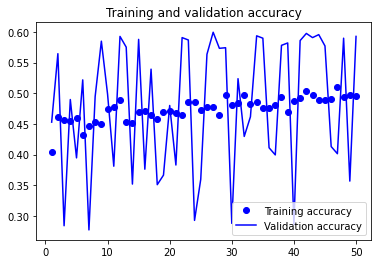

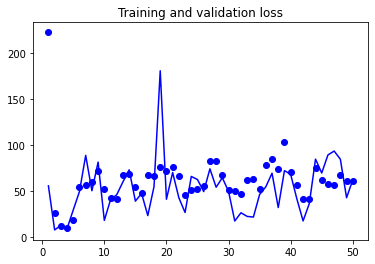

              precision    recall  f1-score   support

           0       0.08      0.00      0.01       237
           1       0.00      0.00      0.00       167
           2       1.00      0.90      0.95       155
           3       0.53      0.99      0.69       472

    accuracy                           0.59      1031
   macro avg       0.40      0.47      0.41      1031
weighted avg       0.41      0.59      0.46      1031



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print("Average test loss: ", np.mean(VGG_history.history['loss']))
plot_loss_acc(VGG_history)

VGG_y_pred = np.argmax(VGG_model.predict(X_val),axis=-1)
print(classification_report(Y_test, VGG_y_pred))

VGG certainly underperformed Alexnet, even with data augmentation.

We will try to fine tune our model. This entails the following:

1. Add custom network on top of an already-trained base network
2. Freeze the base network
3. Train the part we added
4. Unfreeze some layers in the base network
5. Jointly train both these layers and the part we added

We have alread done the first three.

We'll fine tune the last 3 layers (conv). This is because earlier layers in the conv base encode more generic features, and higher up layers encode specialized features. So we will go after the more specialized features. Note, the more parameter you train, the higher the risk of overfitting.

In [ ]:
#We will unfreeze the top 4 layers
conv_base.trainable=True
for layer in conv_base.layers[:-4]:
  layer.trainable=False

In [ ]:
VGG_model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=1e-5), # the lower learning rate is so we can limit the magnitude of the modifications we make to the representations of the 3 layers we are working with
              metrics=['accuracy'])
callbacks=[
        keras.callbacks.ModelCheckpoint(
            filepath='VGG_fine_tuning.keras',
            save_best_only=True,
            monitor='val_loss'
        )   
]
VGG_history_v2=VGG_model.fit(
    X_train,y_train,
    epochs=30,batch_size=20,verbose=1,
    validation_data=(X_val,y_val),
    callbacks=callbacks
)

Epoch 1/30
121/121 [==============================] - 4s 32ms/step - loss: 29.7519 - accuracy: 0.5657 - val_loss: 16.7649 - val_accuracy: 0.6043
Epoch 2/30
121/121 [==============================] - 3s 28ms/step - loss: 26.3606 - accuracy: 0.5362 - val_loss: 14.8401 - val_accuracy: 0.6072
Epoch 3/30
121/121 [==============================] - 3s 28ms/step - loss: 26.4000 - accuracy: 0.5295 - val_loss: 14.5796 - val_accuracy: 0.6081
Epoch 4/30
121/121 [==============================] - 2s 16ms/step - loss: 24.7292 - accuracy: 0.5312 - val_loss: 14.6058 - val_accuracy: 0.6052
Epoch 5/30
121/121 [==============================] - 4s 30ms/step - loss: 24.0090 - accuracy: 0.5495 - val_loss: 13.8047 - val_accuracy: 0.6062
Epoch 6/30
121/121 [==============================] - 3s 28ms/step - loss: 23.9454 - accuracy: 0.5187 - val_loss: 13.5301 - val_accuracy: 0.6101
Epoch 7/30
121/121 [==============================] - 3s 28ms/step - loss: 22.7102 - accuracy: 0.5403 - val_loss: 13.4674 - val_ac

Let's plot the data and see the results

Average test loss:  18.302292601267496


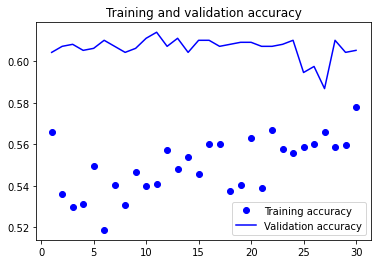

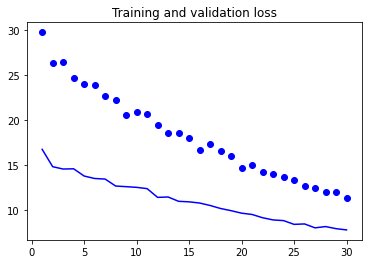

              precision    recall  f1-score   support

           0       0.45      0.15      0.23       237
           1       0.49      0.37      0.42       167
           2       0.94      0.90      0.92       155
           3       0.56      0.81      0.66       472

    accuracy                           0.60      1031
   macro avg       0.61      0.56      0.56      1031
weighted avg       0.58      0.60      0.56      1031



In [ ]:
print("Average test loss: ", np.mean(VGG_history_v2.history['loss']))
plot_loss_acc(VGG_history_v2)

VGG_y_pred_v2 = np.argmax(VGG_model.predict(X_val),axis=-1)
print(classification_report(Y_test, VGG_y_pred_v2))

The results seem slightly better. Let's try one more model!

## MODEL 3:  

I also wanted to try Xception model and see if that would give any better results

Epoch 1/100
121/121 [==============================] - 4s 33ms/step - loss: 195.8332 - accuracy: 0.3989 - val_loss: 58.0233 - val_accuracy: 0.5703
Epoch 2/100
121/121 [==============================] - 4s 34ms/step - loss: 23.2394 - accuracy: 0.4642 - val_loss: 15.0364 - val_accuracy: 0.3472
Epoch 3/100
121/121 [==============================] - 4s 29ms/step - loss: 8.4823 - accuracy: 0.4780 - val_loss: 9.5642 - val_accuracy: 0.3550
Epoch 4/100
121/121 [==============================] - 2s 15ms/step - loss: 11.4816 - accuracy: 0.4659 - val_loss: 16.9370 - val_accuracy: 0.5829
Epoch 5/100
121/121 [==============================] - 2s 15ms/step - loss: 32.5700 - accuracy: 0.4443 - val_loss: 22.1741 - val_accuracy: 0.3841
Epoch 6/100
121/121 [==============================] - 2s 15ms/step - loss: 68.3492 - accuracy: 0.4413 - val_loss: 85.8821 - val_accuracy: 0.5490
Epoch 7/100
121/121 [==============================] - 2s 15ms/step - loss: 69.4044 - accuracy: 0.4676 - val_loss: 51.8562 - 

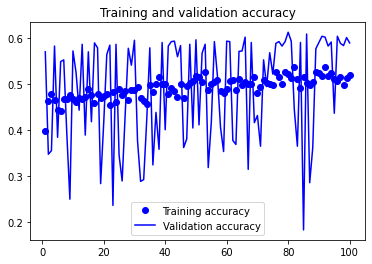

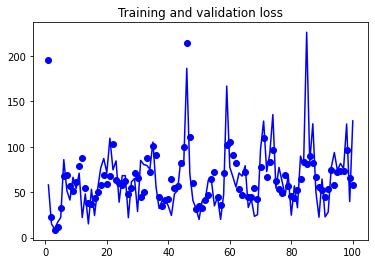

              precision    recall  f1-score   support

           0       1.00      0.00      0.01       237
           1       0.00      0.00      0.00       167
           2       1.00      0.90      0.95       155
           3       0.53      1.00      0.69       472

    accuracy                           0.59      1031
   macro avg       0.63      0.48      0.41      1031
weighted avg       0.62      0.59      0.46      1031



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
X_conv_base=keras.applications.xception.Xception(
    weights='imagenet', #weight checkpoint from which to initialize the model
    include_top=False,#not includethe densely connected classifier on top of the network since we will use our 4 classes
    input_shape=(w,h,d) #shape of image tensors
)
inputs=keras.Input(shape=(w,h,d))
x=data_augmentation(inputs)
x=keras.applications.xception.preprocess_input(x)
x=X_conv_base(x)
x=layers.Flatten()(inputs)
x=layers.Dense(256)(x)
x=layers.Dropout(0.5)(x)
outputs=layers.Dense(num_classes,activation='sigmoid')(x)
X_model=keras.Model(inputs,outputs)
X_model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.01),
              metrics=['accuracy'])
callbacks=[
           keras.callbacks.ModelCheckpoint(
           filepath='X_feature_extraction_with_dat_aug.keras',
           save_best_only=True,
           monitor='val_loss'
)]
X_history=X_model.fit(
    X_train,y_train,
    epochs=100,batch_size=20,verbose=1,
    validation_data=(X_val,y_val),
    callbacks=callbacks
)
print("Average test loss for X_feature_extraction_with_dat_aug: ", np.mean(X_history.history['loss']))
plot_loss_acc(X_history)

X_y_pred = np.argmax(X_model.predict(X_val),axis=-1)
print(classification_report(Y_test, X_y_pred))

X_conv_base.trainable=True
for layer in X_conv_base.layers[:-4]:
  layer.trainable=False



In [ ]:
X_model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=1e-5), # the lower learning rate is so we can limit the magnitude of the modifications we make to the representations of the 3 layers we are working with
              metrics=['accuracy'])
callbacks=[
        keras.callbacks.ModelCheckpoint(
            filepath='X2_fine_tuning.keras',
            save_best_only=True,
            monitor='val_loss'
        )   
]
X2_history_v2=X_model.fit(
    X_train,y_train,
    epochs=100,batch_size=20,verbose=1,
    validation_data=(X_val,y_val),
    callbacks=callbacks
)


Epoch 1/100
121/121 [==============================] - 5s 35ms/step - loss: 107.5996 - accuracy: 0.5907 - val_loss: 89.3530 - val_accuracy: 0.5936
Epoch 2/100
121/121 [==============================] - 4s 31ms/step - loss: 74.1170 - accuracy: 0.5965 - val_loss: 58.7428 - val_accuracy: 0.5897
Epoch 3/100
121/121 [==============================] - 4s 31ms/step - loss: 50.3794 - accuracy: 0.5932 - val_loss: 37.9163 - val_accuracy: 0.5994
Epoch 4/100
121/121 [==============================] - 4s 34ms/step - loss: 35.6369 - accuracy: 0.6019 - val_loss: 26.8136 - val_accuracy: 0.5936
Epoch 5/100
121/121 [==============================] - 4s 33ms/step - loss: 29.0501 - accuracy: 0.5874 - val_loss: 20.7386 - val_accuracy: 0.6033
Epoch 6/100
121/121 [==============================] - 4s 31ms/step - loss: 25.6409 - accuracy: 0.5815 - val_loss: 17.8550 - val_accuracy: 0.6062
Epoch 7/100
121/121 [==============================] - 4s 33ms/step - loss: 23.9833 - accuracy: 0.5936 - val_loss: 16.8332 

Average test loss for X2_fine_tuning:  11.86680334329605


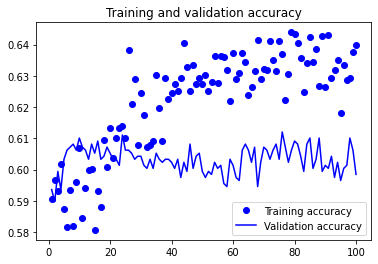

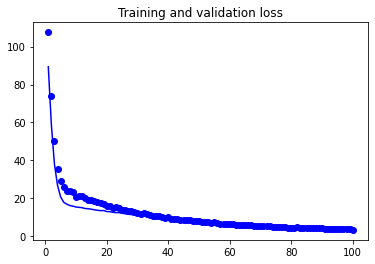

              precision    recall  f1-score   support

           0       0.43      0.33      0.38       237
           1       0.50      0.40      0.44       167
           2       0.94      0.90      0.92       155
           3       0.59      0.70      0.64       472

    accuracy                           0.60      1031
   macro avg       0.61      0.58      0.59      1031
weighted avg       0.59      0.60      0.59      1031



In [ ]:
print("Average test loss for X2_fine_tuning: ", np.mean(X2_history_v2.history['loss']))
plot_loss_acc(X2_history_v2)

X2_y_pred = np.argmax(X_model.predict(X_val),axis=-1)
print(classification_report(Y_test, X2_y_pred))

## Conclusion:
 

|Models          | Precision|Recall|Accuracy   |F1    |
|------|-------|---------|-------------|----------|  
|AlexNet    |   0.73   |  0.70   |  0.71  |0.70   
|AlexNet with Image Augmentation|0.20|0.29|0.44|0.23 
|VGG16 with Image Augmentation and Regularization|     0.40  | 0.47 | 0.59 |0.41  
|VGG16 Fine Tuned|   0.62  |  0.56  |  0.60  | 0.57    
|Xception with Image Augmentation and Regularization|0.63 |0.48 |0.59 |0.41 |  
|Xception Fine Tuned| 0.61|0.58 |0.60 |0.59 |  



Clearly, AlexNet performed the best overall.

# Task 2: Visualizing Regions of Interest

We will be working on visualizing the feature activations and subsequently generate some saliency heatmaps using gradCAM method. CAM in gradCAM stands for Class Activation Map and grad is for Gradient. it is a 2D grid of scores associated with a specific output class, computed for every location in any image(input), depicting the importance w.r.t. the class under consideration.



In [ ]:
Alex_model.summary()

Model: "alex_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 62, 62, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 30, 30, 256)      1024      
 hNormalization)                                                 
                                                          

Let's get the predicted values for our validation features and save them as `pred_values`

In [ ]:
pred_values=Alex_model.predict(X_val)

In [ ]:
print("The probabilities for image 10 in the Validation list are {}".format(np.round(pred_values[10],2)))
print("This highest probability is at index {}".format(np.argmax(pred_values[10],axis=-1)))
print("This index no. pertains to the following class: {}".format(categories[Alex_pred[10]]))

The probabilities for image 10 in the Validation list are [0.97 0.   0.18 0.03]
This highest probability is at index 0
This index no. pertains to the following class: diabetic retinopathy


## Setting up the CAM

To set up the AF Map, we will start by identifying the classifier layer names and the convolution layer name, since that is where the more nuanced feature extraction takes place.

In [ ]:
last_conv_layer_name='conv2d_4'
classifier_layer_names=[
                        'max_pooling2d_2',
                        'flatten',
                        'dense'
]
last_conv_layer=Alex_model.get_layer(last_conv_layer_name)
last_conv_layer_model=keras.Model(Alex_model.inputs,last_conv_layer.output)

We will now create a function to take in the input image and the layers identified just now and our classifiaction model and output our heatmap in numpy format. The function was used from the keras website examples.

In [ ]:
def make_gradcam_heatmap(img, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    img_array = np.expand_dims(img, axis=0)
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

Let's visualize an example heatmap

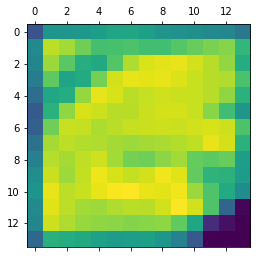

In [ ]:
hmap = make_gradcam_heatmap(X_train[0], Alex_model, last_conv_layer_name)
plt.matshow(hmap)
plt.show()

Note this is just the gradient mapping, it just shows the regions of interest, which will become clearer with the actual retina image superimposed.

## Superimposing the gradCAM on the Image

In [ ]:
from IPython.display import Image

We will create another function for visualizing a superimposed heatmap given a training image index number

In [ ]:
def show_heatmap(idx):
  img_class = categories[np.argmax(y_train[idx], axis=-1)]
  print('This image pertains to the {} class'.format(img_class))
  img = X_train[idx]
  heatmap = make_gradcam_heatmap(img, Alex_model, last_conv_layer_name)
  heatmap = np.uint8(255 * heatmap)
  img = img * 255.
  # We use jet colormap to colorize heatmap
  jet = cm.get_cmap("jet")

  # We use RGB values of the colormap
  jet_colors = jet(np.arange(256))[:, :3]
  jet_heatmap = jet_colors[heatmap]

  # We create an image with RGB colorized heatmap
  jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
  jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
  jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

  # Superimpose the heatmap on original image
  superimposed_img = jet_heatmap * 0.5 + img
  superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

  # Save the superimposed image
  save_path = "./results/"
  filename=f'X_train{idx}{img_class}.jpg'
  if not os.path.exists(save_path):
    os.makedirs(save_path)
  full_path=os.path.join(save_path,filename)
  superimposed_img.save(full_path)

  # Display Grad CAM
  return display(Image(full_path))

## Individual Analysis


We will look at 5 images from each category.

### Diabetic Retinopathy

Diabetic retinopathy is when there is some blood vessel damage. So essentially hemorhaging spots might be one indication on the retinal scans

This image pertains to the diabetic retinopathy class


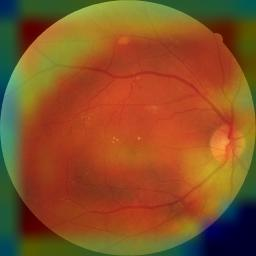

This image pertains to the diabetic retinopathy class


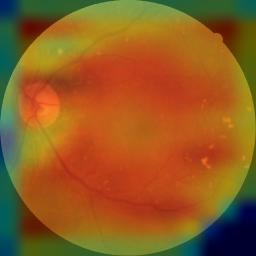

This image pertains to the diabetic retinopathy class


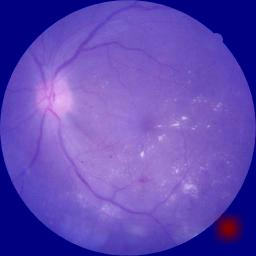

This image pertains to the diabetic retinopathy class


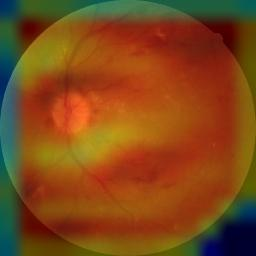

This image pertains to the diabetic retinopathy class


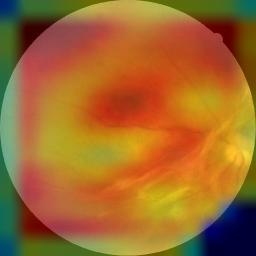

In [ ]:
#We will look at 5 images for each class in our dataset
for i in np.where(y_train[:,0]==1)[0][:5]:
  show_heatmap(i)

As you can see there are some distinct dark spotting within the mapping of images that may correlate with our intuition of the disease. 

### Glaucoma

Galucoma is relevant to pressure build-up, affecting the optic nerve, which in certain cases enlarges the optic and the nerve head on top of it

This image pertains to the glaucoma class


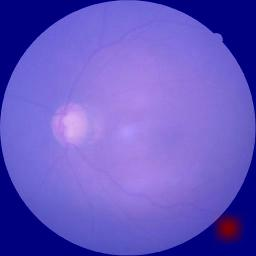

This image pertains to the glaucoma class


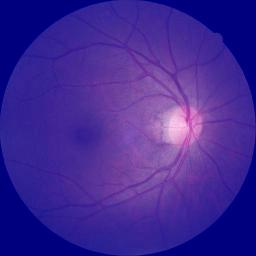

This image pertains to the glaucoma class


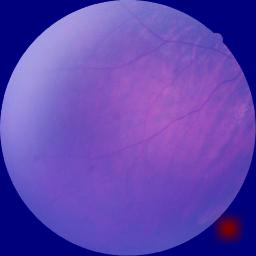

This image pertains to the diabetic retinopathy class


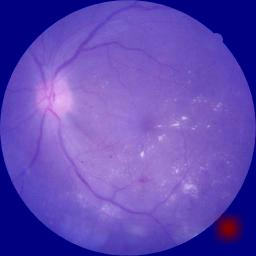

This image pertains to the glaucoma class


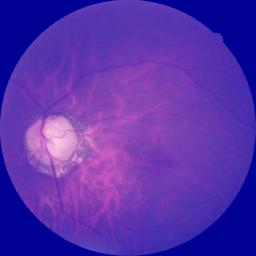

In [ ]:
for i in np.where(y_train[:,1]==1)[0][:5]:
  show_heatmap(i)

We found a multi-label problem. This is diabetic retinopathy as well as galucoma. It seems like the thickness of the nerve can be one determinant. 

### Normal

The normal class certainly seems to have no mapping or regions of more or less importance, which just shows up as a mask

This image pertains to the normal class


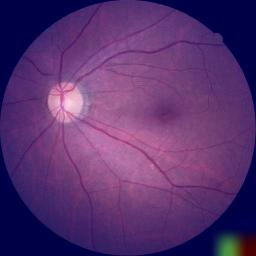

This image pertains to the normal class


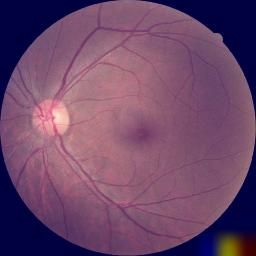

This image pertains to the normal class


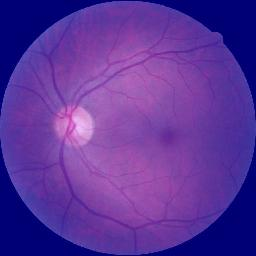

This image pertains to the normal class


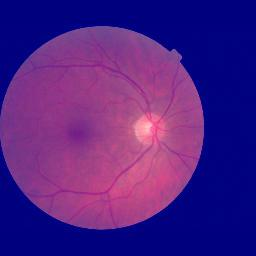

This image pertains to the normal class


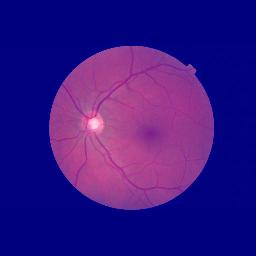

In [ ]:
for i in np.where(y_train[:,2]==1)[0][:5]:
  show_heatmap(i)

### Other

The other category basically covers the other diseases that were mentioned at the beginning of task 1. Again, you can see the gradient mapping contrasting with areas of high and low interest

This image pertains to the other class


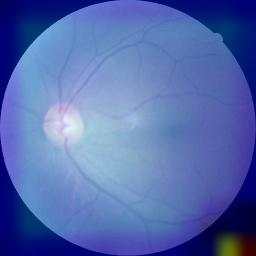

This image pertains to the other class


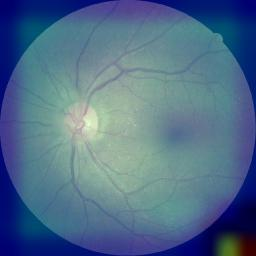

This image pertains to the other class


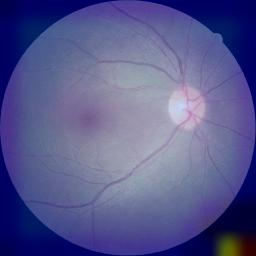

This image pertains to the other class


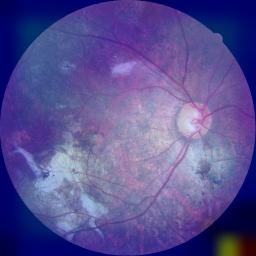

This image pertains to the other class


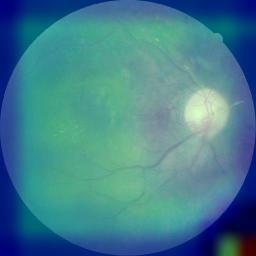

In [ ]:
for i in np.where(y_train[:,3]==1)[0][:5]:
  show_heatmap(i)

# Task 3: Semi-supervised Learning

We would be doing three things:  
1. Pass the unlabelled images through the trained model and retrieve the dense layer features prior to the classification layer. Using this dense layer as representative of the image, apply label propagation using these features in order to retrieve labels corresponding to the unlabeled data.
2. Next, concatenate the train data with the unlabeled data (that has now been self-labeled) and retrain the network, either from scratch or just fine-tuning, up to us.
3. Report classification performance on the labeled validation data we generated in Task 1

**Step 1:**

In [ ]:
dense_layer = 'dense'
dense_model = keras.Model(inputs=Alex_model.input,
                    outputs=Alex_model.get_layer(dense_layer).output)

In [ ]:
# Pass labeled and unlabeled data
l_dense_output = dense_model.predict(X_train)
ul_dense_output = dense_model.predict(X_test)

In [ ]:
#combine both predictions of the dense layers
dense_output = np.concatenate((l_dense_output, ul_dense_output), axis=0)


In [ ]:
# Convert from one hot encoding to indices
class_labels = np.argmax(y_train, axis=1).reshape(-1,1)

In [ ]:
# pad the y variable containing the indices with -1 for our label propagation step
ones=-np.ones((len(X_test),1))
y_full = np.concatenate((class_labels, ones), axis=0)
print("Shape of y: {}".format( y_full.shape))
print("Shape of X: {}".format(dense_output.shape))

So what we have now is a y and an x: 


      ```
      y or y_full = (indexed y_train) + (-1s for 350 testing rows) #this is indexed so we have the index value for each category  
      x or dense_output= (one hot encoded predicted y_train)+(one hot encoded predicted y_test)
      ```



In [ ]:
from sklearn.semi_supervised import LabelPropagation

# Fit label propagation model
lp_model = LabelPropagation(kernel='knn', n_neighbors=4,n_jobs=-1)
lp_model.fit(dense_output, y_full.ravel())


LabelPropagation(kernel='knn', n_jobs=-1, n_neighbors=4)

In [ ]:
#generate class label indices for only the testing data so we can see the metrics
class_labels_dense = np.argmax(ul_dense_output, axis=1).reshape(-1,1)

In [ ]:
print(classification_report(class_labels_dense,lp_model.transduction_[len(X_train):]))

              precision    recall  f1-score   support

           0       0.97      0.61      0.75       114
           1       0.64      1.00      0.78        37
           2       0.98      1.00      0.99        49
           3       0.82      0.93      0.87       150

    accuracy                           0.85       350
   macro avg       0.85      0.89      0.85       350
weighted avg       0.87      0.85      0.84       350



**Step 2:**

In [ ]:
#Let's get the prediction out of our labelpropagation model using transduction and convert it back to one-hot-encoding for our next step
lp_predictions=lp_model.transduction_
y_full = np.array(pd.get_dummies(lp_predictions))

In [ ]:
#Combine the training data together
X_full = np.concatenate((X_train, X_test), axis=0)

In [ ]:
fromscratch_model=AlexNet(input_shape=X_train.shape[1:],num_classes=y_train.shape[1])
#fit our model to the updated data from earlier
fromscratch_history=fromscratch_model.fit(X_full,y_full,validation_split=0.2,epochs=50,batch_size=20,verbose=1,callbacks=[tensorboard_callback])

print("Average test loss: ", np.mean(fromscratch_history.history['loss']))


Epoch 1/50
111/111 [==============================] - 5s 39ms/step - loss: 2.2610 - accuracy: 0.4321 - val_loss: 3.4034 - val_accuracy: 0.5390
Epoch 2/50
111/111 [==============================] - 4s 32ms/step - loss: 0.5972 - accuracy: 0.4793 - val_loss: 1.5382 - val_accuracy: 0.2269
Epoch 3/50
111/111 [==============================] - 4s 32ms/step - loss: 0.4512 - accuracy: 0.5538 - val_loss: 0.6329 - val_accuracy: 0.5844
Epoch 4/50
111/111 [==============================] - 4s 32ms/step - loss: 0.4336 - accuracy: 0.5597 - val_loss: 0.5600 - val_accuracy: 0.4465
Epoch 5/50
111/111 [==============================] - 4s 32ms/step - loss: 0.4223 - accuracy: 0.5679 - val_loss: 0.4617 - val_accuracy: 0.5318
Epoch 6/50
111/111 [==============================] - 4s 32ms/step - loss: 0.3989 - accuracy: 0.5987 - val_loss: 0.4031 - val_accuracy: 0.6189
Epoch 7/50
111/111 [==============================] - 4s 38ms/step - loss: 0.3895 - accuracy: 0.6201 - val_loss: 0.4324 - val_accuracy: 0.6116

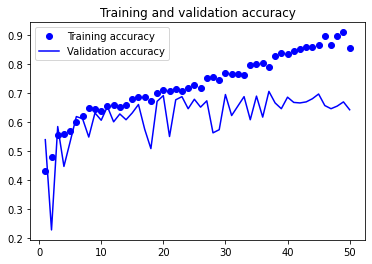

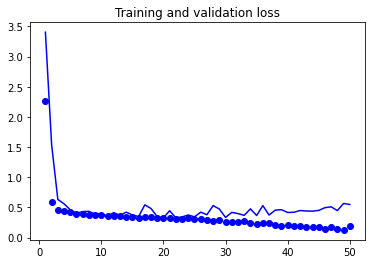

In [ ]:
plot_loss_acc(fromscratch_history)

**Step 3:** Reporting classification metrics on validation data

In [ ]:
fromscratch_model.save('from_scratch.h5')

In [ ]:
fromscratch_y_pred = np.argmax(fromscratch_model.predict(X_val),axis=-1)
print(classification_report(Y_test, fromscratch_y_pred))

              precision    recall  f1-score   support

           0       0.61      0.32      0.42       237
           1       0.43      0.68      0.52       167
           2       0.99      0.90      0.95       155
           3       0.71      0.75      0.73       472

    accuracy                           0.66      1031
   macro avg       0.68      0.66      0.65      1031
weighted avg       0.68      0.66      0.66      1031



# Conclusion:
 

|Models          | Precision|Recall|Accuracy   |F1    |
|------|-------|---------|-------------|----------|  
|AlexNet    |   0.73   |  0.70   |  0.71  |0.70   
|AlexNet with Image Augmentation|0.20|0.29|0.44|0.23 
|VGG16 with Image Augmentation and Regularization|     0.40  | 0.47 | 0.59 |0.41  
|VGG16 Fine Tuned|   0.62  |  0.56  |  0.60  | 0.57    
|Xception with Image Augmentation and Regularization|0.63 |0.48 |0.59 |0.41 |  
|Xception Fine Tuned| 0.61|0.58 |0.60 |0.59 |  
|AlexNet with unsupervised learning predictions|0.68|0.66|0.66|0.65|  


As the table shows, AlexNet original still outperformed the AlexNet with more data. It was an interesting excericise to understand the steps that can be taken to fine tune models.